In [61]:
import os
import pandas
import yfinance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

# Choose Ticker to Analyze
ticker = "SNAP"

# Main
DATA_PATH = f"{ticker}_data.json"

if os.path.exists(DATA_PATH):
    with open(DATA_PATH) as f:
        stock_hist = pandas.read_json(DATA_PATH)
else:
    stock = yfinance.Ticker(ticker)
    stock_hist = stock.history(period="max")

    stock_hist.to_json(DATA_PATH)

In [62]:
stock_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-03-02 00:00:00-05:00,24.000000,26.049999,23.500000,24.480000,217048900,0.0,0.0
2017-03-03 00:00:00-05:00,26.389999,29.440001,26.059999,27.090000,148166400,0.0,0.0
2017-03-06 00:00:00-05:00,28.170000,28.250000,23.770000,23.770000,72903000,0.0,0.0
2017-03-07 00:00:00-05:00,22.209999,22.500000,20.639999,21.440001,71857800,0.0,0.0
2017-03-08 00:00:00-05:00,22.030001,23.430000,21.309999,22.809999,49819100,0.0,0.0


<Axes: xlabel='Date'>

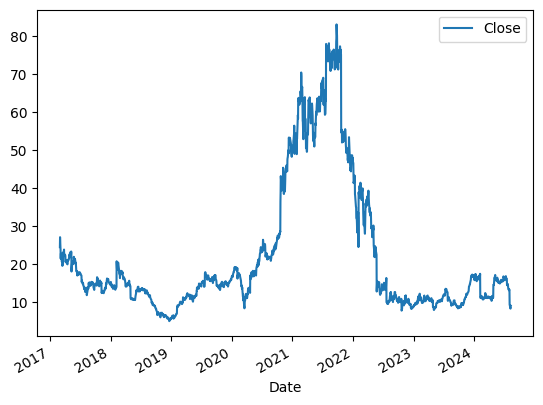

In [63]:
stock_hist.plot.line(y="Close", use_index=True)

In [64]:
data = stock_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Identifies if the price went up or down
data["Target"] = stock_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [65]:
# Shift stock prices forward
stock_prev = stock_hist.copy()
stock_prev = stock_prev.shift(1)

In [66]:
# Create training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(stock_prev[predictors]).iloc[1:]

In [67]:
data.head(5)

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
2017-03-03 00:00:00-05:00,27.090000,1.0,24.480000,217048900.0,24.000000,26.049999,23.500000
2017-03-06 00:00:00-05:00,23.770000,0.0,27.090000,148166400.0,26.389999,29.440001,26.059999
2017-03-07 00:00:00-05:00,21.440001,0.0,23.770000,72903000.0,28.170000,28.250000,23.770000
2017-03-08 00:00:00-05:00,22.809999,1.0,21.440001,71857800.0,22.209999,22.500000,20.639999
2017-03-09 00:00:00-05:00,22.709999,0.0,22.809999,49819100.0,22.030001,23.430000,21.309999


In [68]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [69]:
preds = model.predict(test[predictors])
preds = pandas.Series(preds, index=test.index)
precision_score(test["Target"], preds)

np.float64(0.5555555555555556)

<Axes: xlabel='Date'>

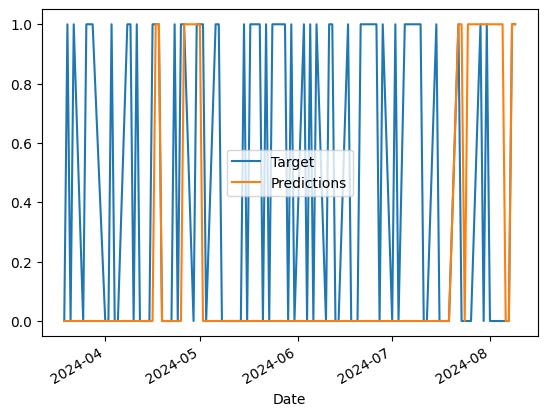

In [70]:
combined = pandas.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

In [71]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        model.fit(train[predictors], train["Target"])
        
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pandas.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        combined = pandas.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pandas.concat(predictions)

In [72]:
predictions = backtest(data, model, predictors)

In [73]:
predictions["Predictions"].value_counts()

Predictions
0.0    801
1.0     71
Name: count, dtype: int64

In [74]:
precision_score(predictions["Target"], predictions["Predictions"])

np.float64(0.4084507042253521)

In [75]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()
weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [76]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [77]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]
predictions = backtest(data.iloc[365:], model, full_predictors)

In [78]:
precision_score(predictions["Target"], predictions["Predictions"])

/home/solidsnakecase/Projects/stock-analysis-bot/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


np.float64(0.0)

In [79]:
predictions["Predictions"].value_counts()

Predictions
0.0    507
Name: count, dtype: int64

<Axes: xlabel='Date'>

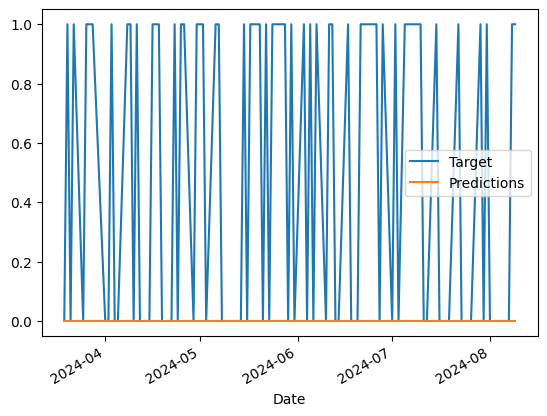

In [80]:
predictions.iloc[-100:].plot()